# TRPO (Trust Region Policy Optimization) 训练

基于论文: "Trust Region Policy Optimization" (Schulman et al., 2015)

## 核心思想

TRPO 通过限制策略更新的步长来保证训练稳定性：
- **Trust Region**: 限制新旧策略之间的 KL 散度不超过阈值 δ
- **自然梯度**: 使用 Fisher 信息矩阵调整梯度方向
- **共轭梯度**: 高效求解 F^{-1}g 而无需显式计算 Fisher 矩阵逆

$$\max_{\theta} \mathbb{E}\left[\frac{\pi_\theta(a|s)}{\pi_{\theta_{old}}(a|s)} A^{\pi_{\theta_{old}}}(s,a)\right]$$
$$\text{s.t. } \mathbb{E}[D_{KL}(\pi_{\theta_{old}} || \pi_\theta)] \leq \delta$$

In [ ]:
# 挂载 Google Drive 保存检查点
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Code/BIT-Embodied-Project/TRPO
import os, sys
sys.path.insert(0, os.path.dirname(os.getcwd()))

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import torch
from collections import deque
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from trpo import TRPOAgent
from envs.games.breakout import BreakoutEnv

## 1. 环境设置

In [2]:
# 创建环境
env = BreakoutEnv(frame_skip=4)

print(f"游戏: {env.get_game_name()}")
print(f"动作空间: {env.get_action_space()}")
print(f"观测形状: {env.get_observation_shape()}")

游戏: Breakout
动作空间: 4
观测形状: (84, 84)


A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


## 2. 帧堆叠工具

In [3]:
class FrameStack:
    """帧堆叠器，将连续 4 帧堆叠为状态"""
    
    def __init__(self, n_frames: int = 4):
        self.n_frames = n_frames
        self.frames = deque(maxlen=n_frames)
    
    def reset(self, frame: np.ndarray) -> np.ndarray:
        """重置并用初始帧填充"""
        for _ in range(self.n_frames):
            self.frames.append(frame)
        return self._get_state()
    
    def step(self, frame: np.ndarray) -> np.ndarray:
        """添加新帧并返回堆叠状态"""
        self.frames.append(frame)
        return self._get_state()
    
    def _get_state(self) -> np.ndarray:
        """返回堆叠的状态 (4, 84, 84)"""
        return np.array(self.frames, dtype=np.uint8)

## 3. 超参数配置

In [4]:
# 训练参数
TOTAL_TIMESTEPS = 10_000_000  # 总训练步数
ROLLOUT_STEPS = 2048          # 每次更新收集的步数
PLOT_INTERVAL = 20_000        # 绘图更新间隔 (实时显示)
EVAL_INTERVAL = 50_000        # 评估间隔
SAVE_INTERVAL = 500_000       # 保存间隔
EVAL_EPISODES = 10            # 每次评估局数（提高评估稳定性）

# Breakout 启动策略
FORCE_FIRE_ON_RESET = True    # 每局开始时是否强制执行一次 FIRE
FORCE_FIRE_ON_EVAL = True     # 评估时是否强制执行一次 FIRE

# 线性搜索稳定器参数（避免过度收紧）
LS_FAIL_THRESHOLD = 80        # 连续线性搜索失败阈值
MAX_KL_DECAY = 0.9            # 触发稳定器时 max_kl 衰减
MIN_MAX_KL = 0.015            # max_kl 下界
DAMPING_GROWTH = 1.1          # 触发稳定器时 damping 增长
MAX_DAMPING = 0.08            # damping 上界

# 线性搜索恢复参数（更新恢复后逐步放宽）
LS_RECOVERY_WINDOW = 80
LS_RECOVERY_THRESHOLD = 0.75
STEPFRAC_RECOVERY_THRESHOLD = 0.30
MAX_KL_RECOVERY_GROWTH = 1.05
DAMPING_RECOVERY_DECAY = 0.95

# 防平台期参数（核心）
ENTROPY_DECAY = 0.9992
MIN_ENTROPY_BEFORE_BREAKTHROUGH = 0.010
MIN_ENTROPY_AFTER_BREAKTHROUGH = 0.002
BREAKTHROUGH_SCORE = 12.0
MAX_ENTROPY_COEF = 0.04
ENTROPY_REHEAT_FACTOR = 1.25
PLATEAU_PATIENCE_EVALS = 8
PLATEAU_MIN_DELTA = 0.2
ROLLBACK_TO_BEST_ON_PLATEAU = True
ROLLBACK_DROP_THRESHOLD = 2.0  # 仅当评估显著下滑才回滚

# TRPO 超参数 (稳定增强版)
config = {
    'n_actions': env.get_action_space(),
    'gamma': 0.99,                  # 折扣因子
    'gae_lambda': 0.95,             # GAE lambda
    'max_kl': 0.025,               # Trust region 约束
    'damping': 0.03,               # Fisher 矩阵阻尼
    'cg_iters': 15,                # 共轭梯度迭代次数
    'backtrack_iters': 15,          # 线性搜索次数
    'backtrack_coeff': 0.8,         # 回溯系数
    'critic_lr': 2e-4,             # Critic 学习率
    'critic_train_iters': 12,      # Critic 训练次数
    'entropy_coef': 0.02,          # 初始熵系数
    'ls_accept_tolerance': 1e-4,   # 线性搜索轻微负改进容忍
    'ls_fallback_tolerance': 5e-4, # 线性搜索回退容忍
    'rollout_steps': ROLLOUT_STEPS,
    'batch_size': 64,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
}

INITIAL_MAX_KL = config['max_kl']
INITIAL_DAMPING = config['damping']

print(f"设备: {config['device']}")
print(f"总训练步数: {TOTAL_TIMESTEPS:,}")
print(
    f"关键参数: max_kl={config['max_kl']}, damping={config['damping']}, "
    f"entropy_coef={config['entropy_coef']}"
)
print(
    f"FIRE 开局: train={FORCE_FIRE_ON_RESET}, eval={FORCE_FIRE_ON_EVAL}"
)
print(
    f"稳定器: fail_th={LS_FAIL_THRESHOLD}, max_kl_decay={MAX_KL_DECAY}, "
    f"min_max_kl={MIN_MAX_KL}, damping_growth={DAMPING_GROWTH}, max_damping={MAX_DAMPING}"
)
print(
    f"恢复器: window={LS_RECOVERY_WINDOW}, ls_ok>={LS_RECOVERY_THRESHOLD}, "
    f"step_frac>={STEPFRAC_RECOVERY_THRESHOLD}"
)
print(
    f"防平台期: patience={PLATEAU_PATIENCE_EVALS}, delta={PLATEAU_MIN_DELTA}, "
    f"breakthrough={BREAKTHROUGH_SCORE}, entropy_floor[pre={MIN_ENTROPY_BEFORE_BREAKTHROUGH}, post={MIN_ENTROPY_AFTER_BREAKTHROUGH}]"
)


设备: cuda
总训练步数: 10,000,000
关键参数: max_kl=0.025, damping=0.03, entropy_coef=0.02
FIRE 开局: train=True, eval=True
稳定器: fail_th=80, max_kl_decay=0.9, min_max_kl=0.015, damping_growth=1.1, max_damping=0.08
恢复器: window=80, ls_ok>=0.75, step_frac>=0.3
防平台期: patience=8, delta=0.2, breakthrough=12.0, entropy_floor[pre=0.01, post=0.002]


## 4. 创建智能体

In [5]:
agent = TRPOAgent(**config)

# 打印网络结构
print("Actor 网络:")
print(agent.actor)
print(f"\nActor 参数量: {sum(p.numel() for p in agent.actor.parameters()):,}")
print(f"Critic 参数量: {sum(p.numel() for p in agent.critic.parameters()):,}")

Actor 网络:
ActorNetwork(
  (conv1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)

Actor 参数量: 1,686,180
Critic 参数量: 1,684,641


## 5. 训练循环

In [6]:
def make_env():
    """创建独立环境实例（用于评估，避免污染训练环境）"""
    return BreakoutEnv(frame_skip=4)


def get_fire_action(env):
    """获取 FIRE 动作索引；若不存在则返回 None"""
    try:
        if hasattr(env, 'unwrapped') and hasattr(env.unwrapped, 'get_action_meanings'):
            meanings = env.unwrapped.get_action_meanings()
            if 'FIRE' in meanings:
                return meanings.index('FIRE')
    except Exception:
        pass
    return 1 if env.get_action_space() > 1 else None


def reset_episode(env, frame_stack, force_fire=False, fire_action=None, max_attempts=3):
    """重置一局，并可选地强制执行 FIRE 启动"""
    frame = env.reset()
    state = frame_stack.reset(frame)
    extra_reward = 0.0

    if not force_fire or fire_action is None:
        return state, extra_reward

    attempts = 0
    while attempts < max_attempts:
        frame, reward, done, _ = env.step(fire_action)
        state = frame_stack.step(frame)
        extra_reward += reward

        if not done:
            return state, extra_reward

        frame = env.reset()
        state = frame_stack.reset(frame)
        attempts += 1

    return state, extra_reward


def evaluate(agent, env_fn, n_episodes=5, force_fire=True):
    """评估智能体性能（使用独立 eval_env）"""
    eval_env = env_fn()
    frame_stack = FrameStack()
    fire_action = get_fire_action(eval_env)
    total_rewards = []

    for _ in range(n_episodes):
        state, episode_reward = reset_episode(
            eval_env,
            frame_stack,
            force_fire=force_fire,
            fire_action=fire_action,
        )
        done = False

        while not done:
            action, _, _ = agent.select_action(state, eval_mode=True)
            frame, reward, done, _ = eval_env.step(action)
            state = frame_stack.step(frame)
            episode_reward += reward

        total_rewards.append(episode_reward)

    if hasattr(eval_env, 'close'):
        eval_env.close()

    return np.mean(total_rewards), np.std(total_rewards)


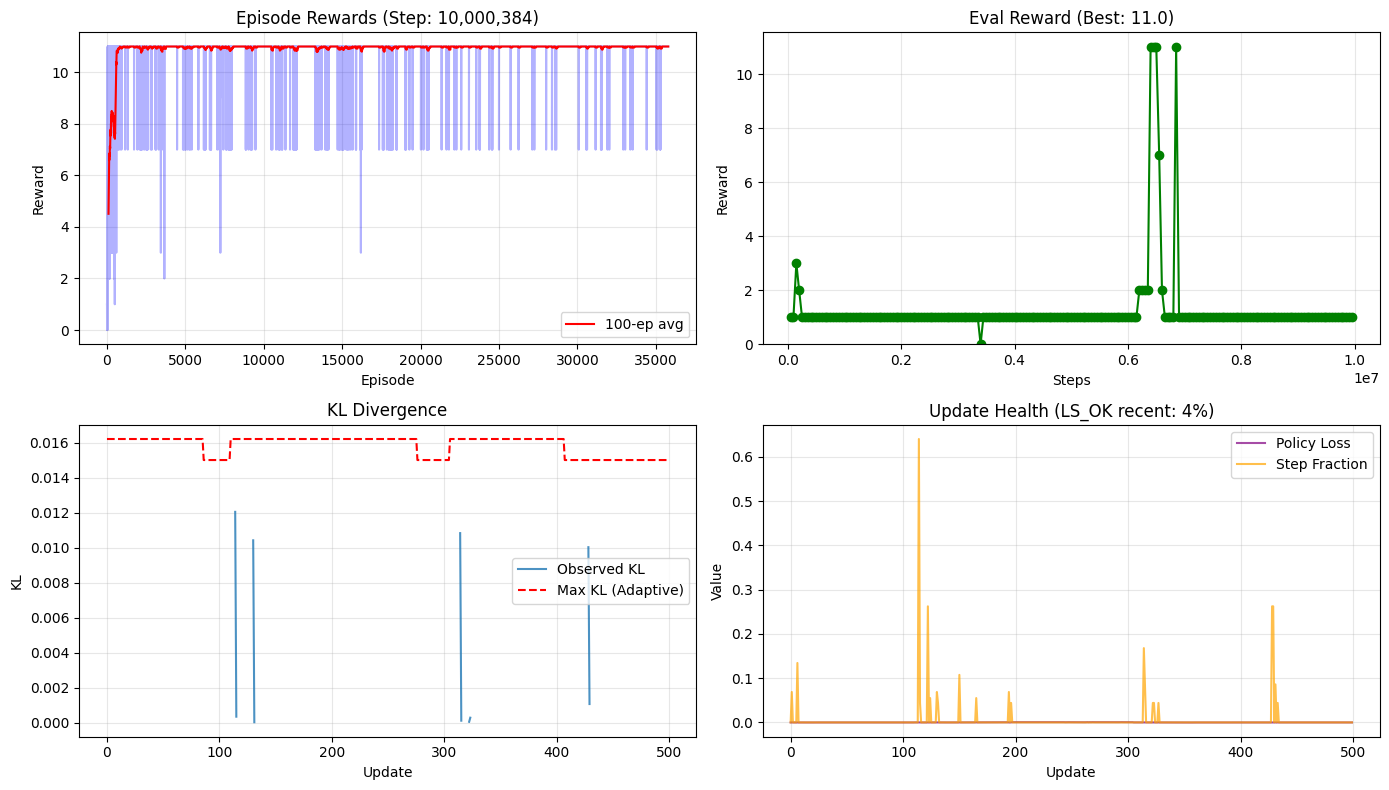

Steps: 10,000,384 | Episodes: 35789 | Avg Reward: 11.0 | Entropy: 0.697 | EntCoef: 0.0342 | EntFloor: 0.0100 | EvalNoImp: 7 | KL: nan | StepFrac: 0.000 | LS_OK: 0% | mode(A/F/R): 0/0/50 | max_kl: 0.0150 | damping: 0.0264 | FPS: 156
  [PlateauRescue#24] eval 长期不提升, eval=1.0, best=11.0, entropy_coef: 0.0342 -> 0.0400, max_kl: 0.0150 -> 0.0162, damping: 0.0264 -> 0.0240, rollback=yes

训练完成! Episodes: 35789, Best Eval: 11.0, LS Success: 7.5%, PlateauRescue: 24
最终 max_kl: 0.0162, 最终 damping: 0.0240, 最终 entropy_coef: 0.0400


In [7]:
from IPython.display import clear_output
import time
import copy

def plot_progress(
    episode_rewards,
    eval_rewards,
    policy_losses,
    kl_divergences,
    max_kl_history,
    step_fractions,
    line_search_successes,
    step,
):
    """实时绘制训练进度"""
    clear_output(wait=True)

    fig, axes = plt.subplots(2, 2, figsize=(14, 8))

    # Episode Rewards
    ax = axes[0, 0]
    if episode_rewards:
        ax.plot(episode_rewards, alpha=0.3, color='blue')
        if len(episode_rewards) >= 50:
            window = min(100, len(episode_rewards))
            avg = np.convolve(episode_rewards, np.ones(window) / window, mode='valid')
            ax.plot(range(window - 1, len(episode_rewards)), avg, color='red', label=f'{window}-ep avg')
            ax.legend()
    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')
    ax.set_title(f'Episode Rewards (Step: {step:,})')
    ax.grid(True, alpha=0.3)

    # Evaluation Rewards
    ax = axes[0, 1]
    if eval_rewards:
        steps, means, stds = zip(*eval_rewards)
        ax.errorbar(steps, means, yerr=stds, capsize=3, marker='o', color='green')
        ax.set_ylim(bottom=0)
    ax.set_xlabel('Steps')
    ax.set_ylabel('Reward')
    ax.set_title(f'Eval Reward (Best: {max([r[1] for r in eval_rewards]) if eval_rewards else 0:.1f})')
    ax.grid(True, alpha=0.3)

    # KL Divergence
    ax = axes[1, 0]
    if kl_divergences:
        ax.plot(kl_divergences[-500:], alpha=0.8, label='Observed KL')
    if max_kl_history:
        ax.plot(max_kl_history[-500:], color='r', linestyle='--', label='Max KL (Adaptive)')
    ax.set_xlabel('Update')
    ax.set_ylabel('KL')
    ax.set_title('KL Divergence')
    ax.grid(True, alpha=0.3)
    ax.legend()

    # Policy updates health
    ax = axes[1, 1]
    if policy_losses:
        ax.plot(policy_losses[-500:], alpha=0.7, color='purple', label='Policy Loss')
    if step_fractions:
        ax.plot(step_fractions[-500:], alpha=0.7, color='orange', label='Step Fraction')
    if line_search_successes:
        ls_rate = np.mean(line_search_successes[-100:]) * 100
        ax.set_title(f'Update Health (LS_OK recent: {ls_rate:.0f}%)')
    else:
        ax.set_title('Update Health')
    ax.set_xlabel('Update')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)
    ax.legend()

    plt.tight_layout()
    plt.show()

# 训练记录
episode_rewards = []
eval_rewards = []
policy_losses = []
critic_losses = []
kl_divergences = []
entropies = []
step_fractions = []
line_search_successes = []
line_search_modes = []
max_kl_history = []
damping_history = []
consecutive_line_search_failures = 0

# 防平台期状态
current_entropy_coef = config['entropy_coef']
eval_no_improve_count = 0
plateau_rescue_count = 0
best_model_state = None

# 初始化
frame_stack = FrameStack()
fire_action = get_fire_action(env)
state, reset_bonus = reset_episode(
    env,
    frame_stack,
    force_fire=FORCE_FIRE_ON_RESET,
    fire_action=fire_action,
)
episode_reward = reset_bonus
episode_count = 0
best_eval_reward = -float('inf')
start_time = time.time()

print("开始训练 TRPO...")
print(f"训练环境 FIRE 动作索引: {fire_action}")

while agent.total_steps < TOTAL_TIMESTEPS:
    # 收集 rollout
    done = False
    for _ in range(ROLLOUT_STEPS):
        action, log_prob, value = agent.select_action(state)
        next_frame, reward, done, info = env.step(action)
        next_state = frame_stack.step(next_frame)

        agent.store_transition(state, action, reward, value, log_prob, done)
        episode_reward += reward
        state = next_state

        if done:
            agent.finish_path(last_value=0.0)
            episode_rewards.append(episode_reward)
            episode_count += 1
            state, reset_bonus = reset_episode(
                env,
                frame_stack,
                force_fire=FORCE_FIRE_ON_RESET,
                fire_action=fire_action,
            )
            episode_reward = reset_bonus

    # Bootstrap if episode not done
    if not done:
        with torch.no_grad():
            state_tensor = torch.from_numpy(state).unsqueeze(0).to(agent.device)
            last_value = agent.critic(state_tensor).item()
        agent.finish_path(last_value=last_value)

    # 设置当前熵系数并更新
    agent.entropy_coef = current_entropy_coef

    # TRPO 更新
    update_info = agent.update()
    policy_losses.append(update_info['policy_loss'])
    critic_losses.append(update_info['critic_loss'])
    kl_divergences.append(update_info['kl_divergence'])
    entropies.append(update_info.get('entropy', 0.0))

    # 分阶段熵退火：没突破前保持更高探索下限
    min_entropy_floor = (
        MIN_ENTROPY_BEFORE_BREAKTHROUGH
        if best_eval_reward < BREAKTHROUGH_SCORE
        else MIN_ENTROPY_AFTER_BREAKTHROUGH
    )
    current_entropy_coef = max(min_entropy_floor, current_entropy_coef * ENTROPY_DECAY)

    step_frac = float(update_info.get('step_fraction', 0.0))
    ls_success = bool(update_info.get('line_search_success', True))
    ls_mode = update_info.get('line_search_mode', 'unknown')
    step_fractions.append(step_frac)
    line_search_successes.append(1.0 if ls_success else 0.0)
    line_search_modes.append(ls_mode)

    # 自适应稳定器：连续线性搜索失败时，收紧 trust region 并增加阻尼
    if ls_success:
        consecutive_line_search_failures = 0
    else:
        consecutive_line_search_failures += 1

    if consecutive_line_search_failures >= LS_FAIL_THRESHOLD:
        old_max_kl = agent.max_kl
        old_damping = agent.damping
        agent.max_kl = max(MIN_MAX_KL, agent.max_kl * MAX_KL_DECAY)
        agent.damping = min(MAX_DAMPING, agent.damping * DAMPING_GROWTH)
        consecutive_line_search_failures = 0

        print(
            f"  [AutoTune-Down] 连续失败达到阈值, "
            f"max_kl: {old_max_kl:.4f} -> {agent.max_kl:.4f}, "
            f"damping: {old_damping:.4f} -> {agent.damping:.4f}"
        )

    # 恢复器：若近期更新健康，则逐步放宽 trust region、降低阻尼
    if len(line_search_successes) >= LS_RECOVERY_WINDOW:
        recent_ls_ok = np.mean(line_search_successes[-LS_RECOVERY_WINDOW:])
        recent_step_frac = np.mean(step_fractions[-LS_RECOVERY_WINDOW:])
        if (
            recent_ls_ok >= LS_RECOVERY_THRESHOLD
            and recent_step_frac >= STEPFRAC_RECOVERY_THRESHOLD
            and (agent.max_kl < INITIAL_MAX_KL or agent.damping > INITIAL_DAMPING)
        ):
            old_max_kl = agent.max_kl
            old_damping = agent.damping
            agent.max_kl = min(INITIAL_MAX_KL, agent.max_kl * MAX_KL_RECOVERY_GROWTH)
            agent.damping = max(INITIAL_DAMPING, agent.damping * DAMPING_RECOVERY_DECAY)

            if agent.max_kl != old_max_kl or agent.damping != old_damping:
                print(
                    f"  [AutoTune-Up] 更新恢复, "
                    f"max_kl: {old_max_kl:.4f} -> {agent.max_kl:.4f}, "
                    f"damping: {old_damping:.4f} -> {agent.damping:.4f}"
                )

    max_kl_history.append(agent.max_kl)
    damping_history.append(agent.damping)

    # 实时绘图
    if agent.total_steps % PLOT_INTERVAL < ROLLOUT_STEPS:
        elapsed = time.time() - start_time
        fps = agent.total_steps / elapsed
        plot_progress(
            episode_rewards,
            eval_rewards,
            policy_losses,
            kl_divergences,
            max_kl_history,
            step_fractions,
            line_search_successes,
            agent.total_steps,
        )

        avg_reward = np.mean(episode_rewards[-100:]) if episode_rewards else 0
        avg_entropy = np.mean(entropies[-50:]) if entropies else 0
        recent_ls_ok = np.mean(line_search_successes[-50:]) * 100 if line_search_successes else 0
        recent_step_frac = np.mean(step_fractions[-50:]) if step_fractions else 0
        recent_accept = sum(m == 'accept' for m in line_search_modes[-50:])
        recent_fallback = sum(m == 'fallback' for m in line_search_modes[-50:])
        recent_revert = sum(m == 'revert' for m in line_search_modes[-50:])
        kl_value = update_info.get('kl_divergence', float('nan'))
        kl_str = f"{kl_value:.4f}" if np.isfinite(kl_value) else "nan"

        print(
            f"Steps: {agent.total_steps:,} | Episodes: {episode_count} | "
            f"Avg Reward: {avg_reward:.1f} | Entropy: {avg_entropy:.3f} | "
            f"EntCoef: {current_entropy_coef:.4f} | EntFloor: {min_entropy_floor:.4f} | "
            f"EvalNoImp: {eval_no_improve_count} | "
            f"KL: {kl_str} | StepFrac: {recent_step_frac:.3f} | "
            f"LS_OK: {recent_ls_ok:.0f}% | "
            f"mode(A/F/R): {recent_accept}/{recent_fallback}/{recent_revert} | "
            f"max_kl: {agent.max_kl:.4f} | damping: {agent.damping:.4f} | FPS: {fps:.0f}"
        )

    # 评估（使用独立 eval_env，避免污染训练状态）
    if agent.total_steps % EVAL_INTERVAL < ROLLOUT_STEPS:
        eval_mean, eval_std = evaluate(
            agent,
            make_env,
            n_episodes=EVAL_EPISODES,
            force_fire=FORCE_FIRE_ON_EVAL,
        )
        eval_rewards.append((agent.total_steps, eval_mean, eval_std))

        if eval_mean > best_eval_reward + PLATEAU_MIN_DELTA:
            best_eval_reward = eval_mean
            eval_no_improve_count = 0
            best_model_state = {
                'actor': copy.deepcopy(agent.actor.state_dict()),
                'critic': copy.deepcopy(agent.critic.state_dict()),
                'critic_optimizer': copy.deepcopy(agent.critic_optimizer.state_dict()),
            }
            agent.save('checkpoints/trpo_best.pt')
            print(f"  *** New best: {eval_mean:.1f} ***")
        else:
            eval_no_improve_count += 1

            # 防平台期：评估长期不提升 -> 提升探索 + 仅在明显退化时回滚
            if eval_no_improve_count >= PLATEAU_PATIENCE_EVALS:
                plateau_rescue_count += 1

                old_entropy_coef = current_entropy_coef
                current_entropy_coef = min(
                    MAX_ENTROPY_COEF,
                    max(current_entropy_coef, min_entropy_floor) * ENTROPY_REHEAT_FACTOR,
                )

                old_max_kl = agent.max_kl
                old_damping = agent.damping
                agent.max_kl = min(INITIAL_MAX_KL * 1.15, max(agent.max_kl, MIN_MAX_KL) * 1.08)
                agent.damping = max(INITIAL_DAMPING * 0.8, agent.damping * 0.85)

                rollback_used = False
                rollback_allowed = (
                    ROLLBACK_TO_BEST_ON_PLATEAU
                    and best_model_state is not None
                    and (best_eval_reward - eval_mean) >= ROLLBACK_DROP_THRESHOLD
                )
                if rollback_allowed:
                    agent.actor.load_state_dict(best_model_state['actor'])
                    agent.critic.load_state_dict(best_model_state['critic'])
                    agent.critic_optimizer.load_state_dict(best_model_state['critic_optimizer'])
                    rollback_used = True

                print(
                    f"  [PlateauRescue#{plateau_rescue_count}] eval 长期不提升, "
                    f"eval={eval_mean:.1f}, best={best_eval_reward:.1f}, "
                    f"entropy_coef: {old_entropy_coef:.4f} -> {current_entropy_coef:.4f}, "
                    f"max_kl: {old_max_kl:.4f} -> {agent.max_kl:.4f}, "
                    f"damping: {old_damping:.4f} -> {agent.damping:.4f}, "
                    f"rollback={'yes' if rollback_used else 'no'}"
                )

                eval_no_improve_count = 0

    # 保存
    if agent.total_steps % SAVE_INTERVAL < ROLLOUT_STEPS:
        agent.save(f'checkpoints/trpo_{agent.total_steps}.pt')

print(
    f"\n训练完成! Episodes: {episode_count}, Best Eval: {best_eval_reward:.1f}, "
    f"LS Success: {np.mean(line_search_successes) * 100 if line_search_successes else 0:.1f}%, "
    f"PlateauRescue: {plateau_rescue_count}"
)
print(
    f"最终 max_kl: {agent.max_kl:.4f}, 最终 damping: {agent.damping:.4f}, "
    f"最终 entropy_coef: {current_entropy_coef:.4f}"
)


## 6. 训练曲线可视化

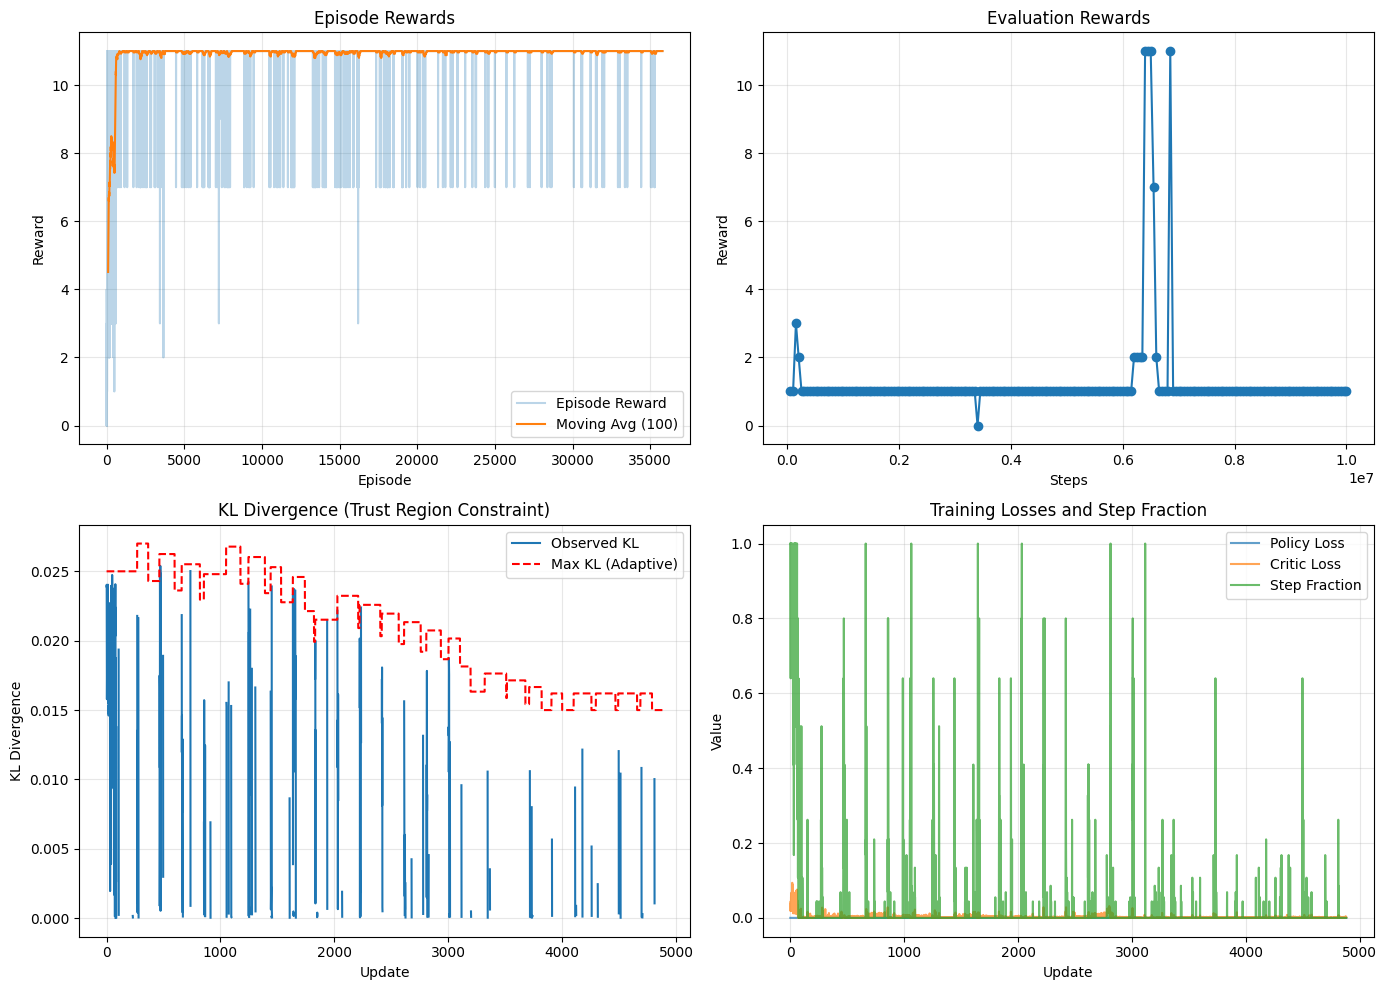

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Episode Rewards
ax = axes[0, 0]
ax.plot(episode_rewards, alpha=0.3, label='Episode Reward')
if len(episode_rewards) >= 100:
    smoothed = np.convolve(episode_rewards, np.ones(100) / 100, mode='valid')
    ax.plot(range(99, len(episode_rewards)), smoothed, label='Moving Avg (100)')
ax.set_xlabel('Episode')
ax.set_ylabel('Reward')
ax.set_title('Episode Rewards')
ax.legend()
ax.grid(True, alpha=0.3)

# Evaluation Rewards
ax = axes[0, 1]
if eval_rewards:
    steps, means, stds = zip(*eval_rewards)
    ax.errorbar(steps, means, yerr=stds, capsize=3, marker='o')
ax.set_xlabel('Steps')
ax.set_ylabel('Reward')
ax.set_title('Evaluation Rewards')
ax.grid(True, alpha=0.3)

# KL Divergence
ax = axes[1, 0]
ax.plot(kl_divergences, label='Observed KL')
if max_kl_history:
    ax.plot(max_kl_history, color='r', linestyle='--', label='Max KL (Adaptive)')
else:
    ax.axhline(y=config['max_kl'], color='r', linestyle='--', label=f'Max KL = {config["max_kl"]}')
ax.set_xlabel('Update')
ax.set_ylabel('KL Divergence')
ax.set_title('KL Divergence (Trust Region Constraint)')
ax.legend()
ax.grid(True, alpha=0.3)

# Losses / Update health
ax = axes[1, 1]
ax.plot(policy_losses, label='Policy Loss', alpha=0.7)
ax.plot(critic_losses, label='Critic Loss', alpha=0.7)
if step_fractions:
    ax.plot(step_fractions, label='Step Fraction', alpha=0.7)
ax.set_xlabel('Update')
ax.set_ylabel('Value')
ax.set_title('Training Losses and Step Fraction')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150)
plt.show()


## 7. 测试训练好的智能体

In [9]:
# 加载最佳模型
agent.load('checkpoints/trpo_best.pt')

# 评估
eval_mean, eval_std = evaluate(agent, make_env, n_episodes=10, force_fire=FORCE_FIRE_ON_EVAL)
print(f"最终评估: {eval_mean:.1f} ± {eval_std:.1f}")

最终评估: 11.0 ± 0.0


In [11]:
# 录制视频
from gymnasium.wrappers import RecordVideo
import gymnasium as gym

# 创建带录制的环境
record_env = gym.make('ALE/Breakout-v5', frameskip=4, render_mode='rgb_array')
record_env = RecordVideo(record_env, 'videos/', episode_trigger=lambda x: True)

frame_stack = FrameStack()
obs, _ = record_env.reset()

# 预处理函数
from envs.wrappers import preprocess_frame
frame = preprocess_frame(obs)
state = frame_stack.reset(frame)

done = False
total_reward = 0

while not done:
    action, _, _ = agent.select_action(state, eval_mode=True)
    obs, reward, terminated, truncated, _ = record_env.step(action)
    done = terminated or truncated
    frame = preprocess_frame(obs)
    state = frame_stack.step(frame)
    total_reward += reward

record_env.close()
print(f"录制完成! 总奖励: {total_reward}")

录制完成! 总奖励: 0.0


## TRPO vs DQN 对比

| 特性 | DQN | TRPO |
|------|-----|------|
| 类型 | Value-based | Policy Gradient |
| 策略 | ε-greedy (隐式) | 显式概率分布 |
| 样本效率 | 高 (off-policy) | 低 (on-policy) |
| 稳定性 | 一般 | 高 (KL 约束) |
| 动作空间 | 离散 | 离散/连续 |
| 内存需求 | 高 (Replay Buffer) | 低 |
| 计算复杂度 | 低 | 高 (共轭梯度) |